# Visualise targets for simulation from IY010_simulation.py

3D plot showing the targets for simulation

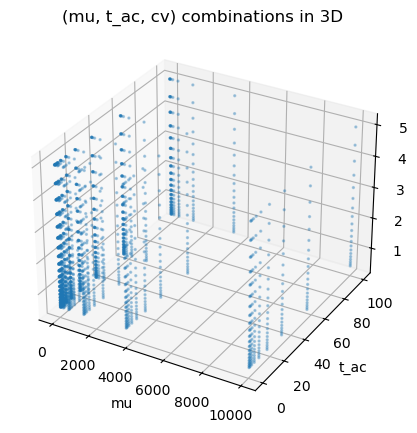

In [33]:
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
# Load the full grid of verified targets (IY010_simulation.py)
mu_target = np.logspace(0, 4, 10)  # 1 to 10000
t_ac_target = np.logspace(-0.3, 2, 10)  # ~0.5 to 100
cv_target = np.logspace(-0.3, 0.7, 20)  # ~0.5 to 5

targets = np.array(np.meshgrid(mu_target, t_ac_target, cv_target)).T.reshape(-1, 3)

# Create a 3D scatter plot of mu vs t_ac vs cv
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(targets[:, 0], targets[:, 1], targets[:, 2], s=2, alpha=0.3)
ax.set_xlabel('mu')
ax.set_ylabel('t_ac')
ax.set_zlabel('cv')
ax.set_title('(mu, t_ac, cv) combinations in 3D')
plt.show()


Data distribution plots for the specified stats

CV values range from 0.50 to 5.01.


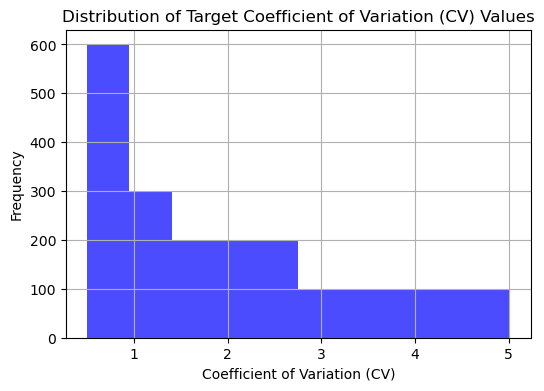

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
df_targets = pd.DataFrame(targets, columns=['mu', 't_ac', 'cv'])
# what ranges of CV values are chosen? 
cv_min = df_targets['cv'].min()
cv_max = df_targets['cv'].max()
print(f"CV values range from {cv_min:.2f} to {cv_max:.2f}.")
# plot the distribution of cv values chosen
plt.figure(figsize=(6, 4))
plt.hist(df_targets['cv'], bins=10, color='blue', alpha=0.7)
plt.xlabel('Coefficient of Variation (CV)')
plt.ylabel('Frequency')
plt.title('Distribution of Target Coefficient of Variation (CV) Values')
plt.grid()  
plt.show()

mu values range from 1.00 to 10000.00.


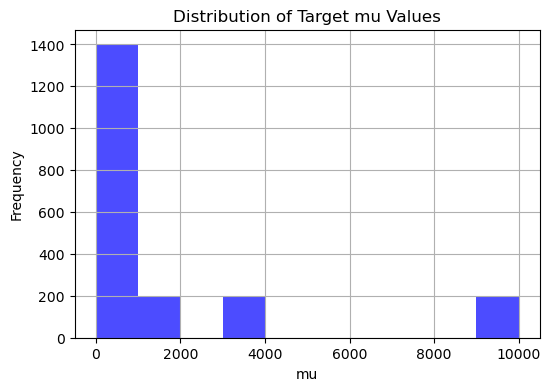

In [35]:
mu_min = df_targets['mu'].min()
mu_max = df_targets['mu'].max()
print(f"mu values range from {mu_min:.2f} to {mu_max:.2f}.")
# plot the distribution 
plt.figure(figsize=(6, 4))
plt.hist(df_targets['mu'], bins=10, color='blue', alpha=0.7)
plt.xlabel('mu')
plt.ylabel('Frequency')
plt.title('Distribution of Target mu Values')
plt.grid()  
plt.show()

t_ac values range from 0.50 to 100.00.


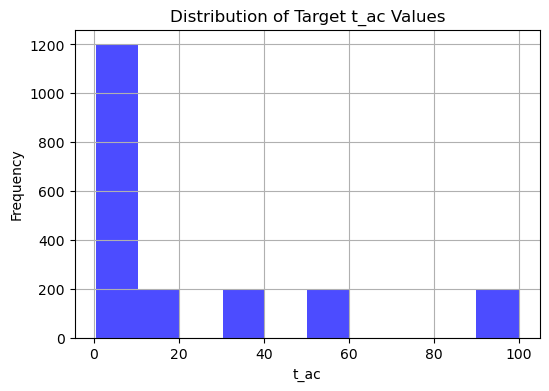

In [36]:
t_ac_min = df_targets['t_ac'].min()
t_ac_max = df_targets['t_ac'].max()
print(f"t_ac values range from {t_ac_min:.2f} to {t_ac_max:.2f}.")
# plot the distribution 
plt.figure(figsize=(6, 4))
plt.hist(df_targets['t_ac'], bins=10, color='blue', alpha=0.7)
plt.xlabel('t_ac')
plt.ylabel('Frequency')
plt.title('Distribution of Target t_ac Values')
plt.grid()  
plt.show()

2D histograms for pairwise parameter combinations

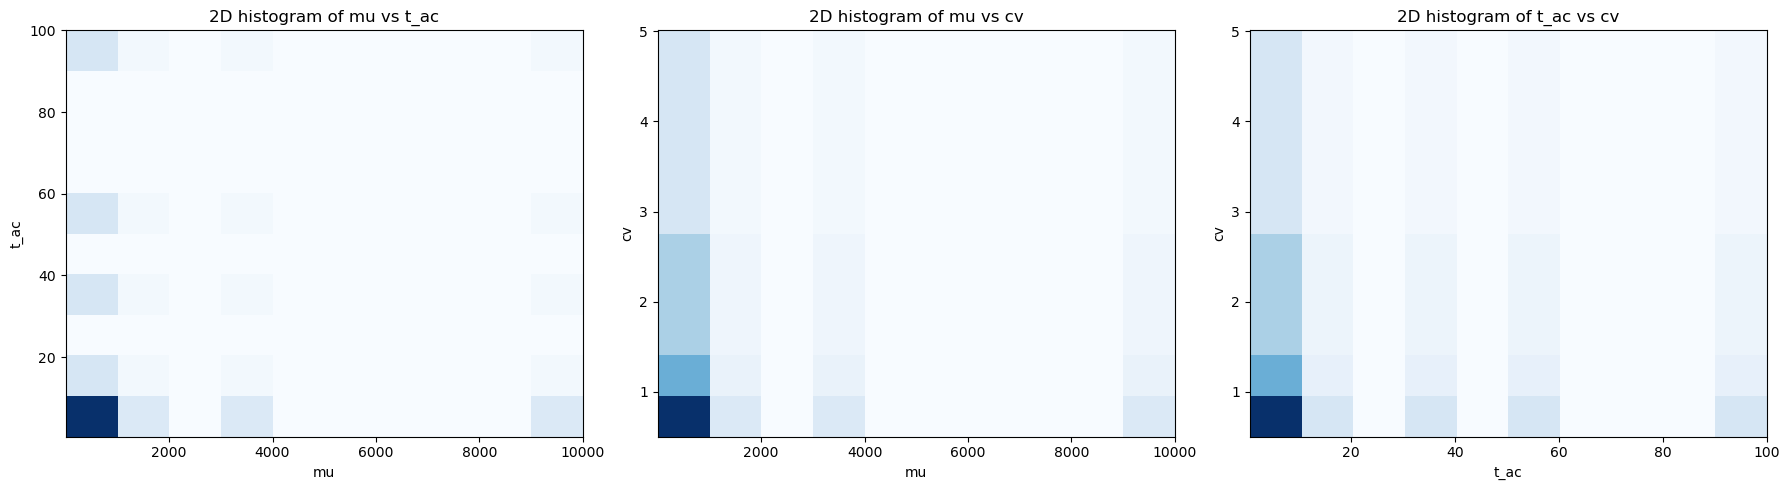

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist2d(df_targets['mu'], df_targets['t_ac'], bins=10, cmap='Blues')
axes[0].set_xlabel('mu')
axes[0].set_ylabel('t_ac')
axes[0].set_title('2D histogram of mu vs t_ac')

axes[1].hist2d(df_targets['mu'], df_targets['cv'], bins=10, cmap='Blues')
axes[1].set_xlabel('mu')
axes[1].set_ylabel('cv')
axes[1].set_title('2D histogram of mu vs cv')

axes[2].hist2d(df_targets['t_ac'], df_targets['cv'], bins=10, cmap='Blues')
axes[2].set_xlabel('t_ac')
axes[2].set_ylabel('cv')
axes[2].set_title('2D histogram of t_ac vs cv')

plt.tight_layout()
plt.show()

## Inspect simulated data stats
Visualise realised vs target statistics

Success rate: 78.85% (1577 out of 2000)


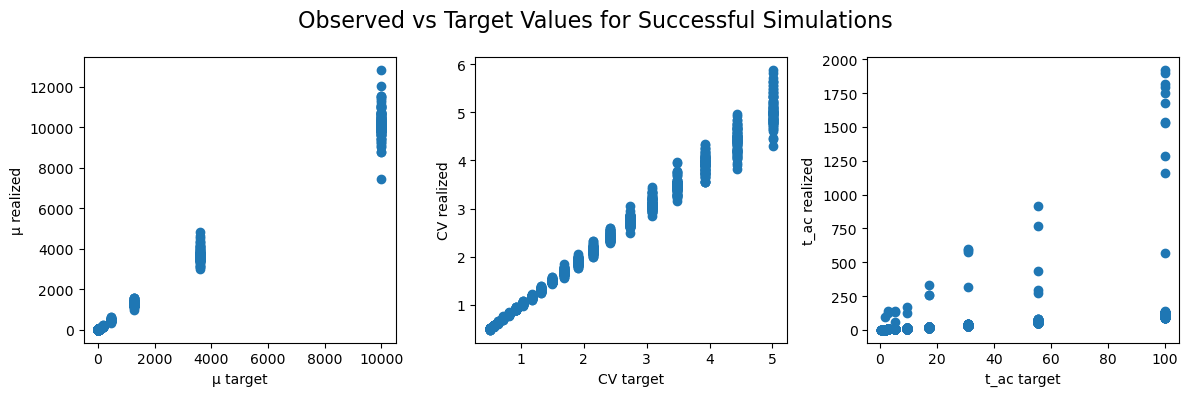

In [38]:
import pandas as pd, numpy as np
from pathlib import Path
from stats.mean import calculate_mean
from stats.variance import calculate_variance
from stats.cv import calculate_cv
from stats.autocorrelation import autocrosscorr, calculate_ac_time_interp1d
import matplotlib.pyplot as plt

data_dir = Path('/home/ianyang/stochastic_simulations/experiments/EXP-25-IY010/data')
# this is the csv file showing the result record with the system parameters, observed stats, rel. errors and trajectory filenames
results = pd.read_csv(f'/home/ianyang/stochastic_simulations/experiments/EXP-25-IY010/data/parameter_testing_results_20250819_094054.csv')
success_results = results[results['success'] == True].reset_index(drop=True)
# print success rate
success_rate = len(success_results) / len(results)
print(f"Success rate: {success_rate:.2%} ({len(success_results)} out of {len(results)})")
# plot comparison
fig, axes = plt.subplots(1,3, figsize=(12,4))
plt.suptitle('Observed vs Target Values for Successful Simulations', fontsize=16)
axes[0].scatter(success_results['mu_target'], success_results['mu_observed'])
axes[0].set_xlabel('μ target'); axes[0].set_ylabel('μ realized')
axes[1].scatter(success_results['cv_target'], success_results['cv_observed'])
axes[1].set_xlabel('CV target'); axes[1].set_ylabel('CV realized')
axes[2].scatter(success_results['t_ac_target'], success_results['t_ac_observed'])
axes[2].set_xlabel('t_ac target'); axes[2].set_ylabel('t_ac realized')
plt.tight_layout()
plt.show()

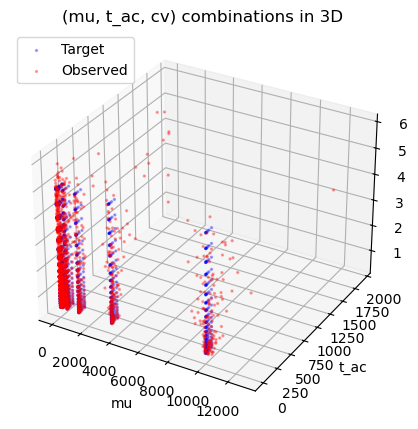

CV target values range from 0.50 to 5.01.
Observed CV values range from 0.48 to 5.89.


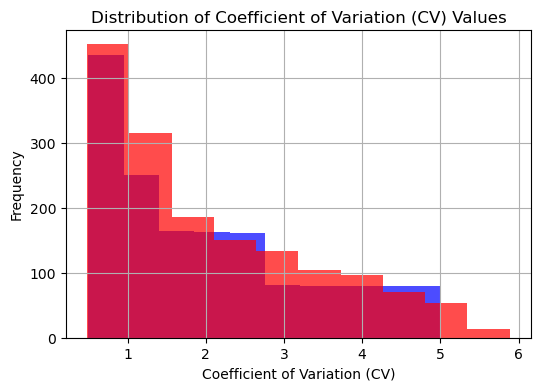

mu target values range from 1.00 to 10000.00.
Observed mu values range from 0.84 to 12852.84.


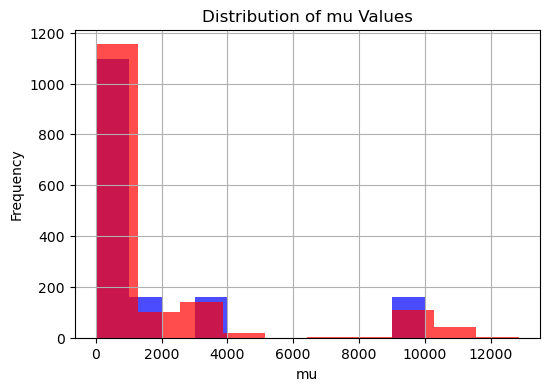

t_ac target values range from 0.50 to 100.00.
Observed t_ac values range from 0.74 to 1923.28.


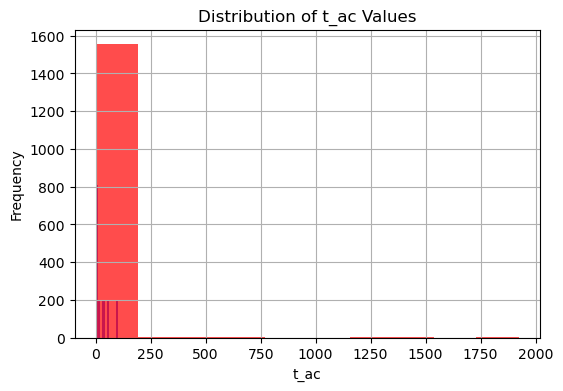

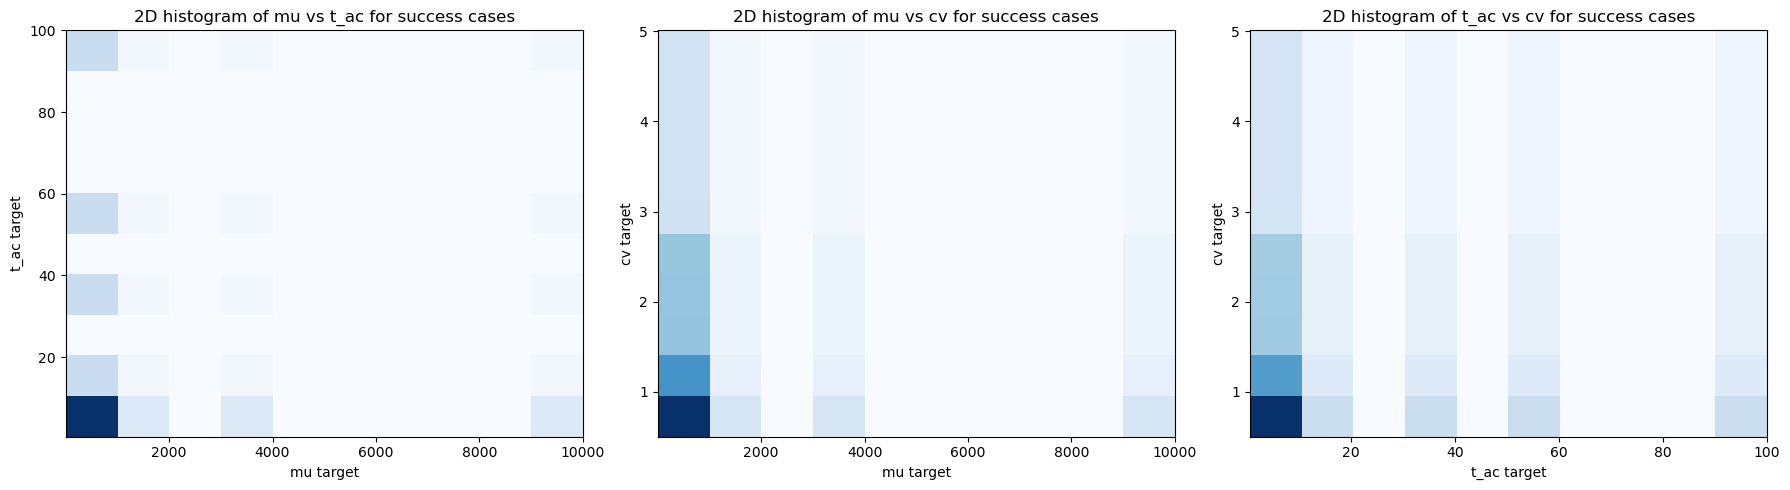

In [24]:
# Create a 3D scatter plot of mu vs t_ac vs cv
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(success_results['mu_target'], success_results['t_ac_target'], success_results['cv_target'], s=2, alpha=0.3, color='blue')
ax.scatter(success_results['mu_observed'], success_results['t_ac_observed'], success_results['cv_observed'], s=2, alpha=0.3, color='red')
ax.legend(['Target', 'Observed'], loc='upper left')
ax.set_xlabel('mu')
ax.set_ylabel('t_ac')
ax.set_zlabel('cv')
ax.set_title('(mu, t_ac, cv) combinations in 3D')
plt.show()
# data distribution plots: CV
cv_target_min = success_results['cv_target'].min()
cv_target_max = success_results['cv_target'].max()
print(f"CV target values range from {cv_target_min:.2f} to {cv_target_max:.2f}.")
cv_observed_min = success_results['cv_observed'].min()
cv_observed_max = success_results['cv_observed'].max()
print(f"Observed CV values range from {cv_observed_min:.2f} to {cv_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['cv_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['cv_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('Coefficient of Variation (CV)')
plt.ylabel('Frequency')
plt.title('Distribution of Coefficient of Variation (CV) Values')
plt.grid()  
plt.show()
# data distribution plots: Mu
mu_target_min = success_results['mu_target'].min()
mu_target_max = success_results['mu_target'].max()
print(f"mu target values range from {mu_target_min:.2f} to {mu_target_max:.2f}.")
mu_observed_min = success_results['mu_observed'].min()
mu_observed_max = success_results['mu_observed'].max()
print(f"Observed mu values range from {mu_observed_min:.2f} to {mu_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['mu_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['mu_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('mu')
plt.ylabel('Frequency')
plt.title('Distribution of mu Values')
plt.grid()  
plt.show()
# data distribution plots: t_ac
t_ac_target_min = success_results['t_ac_target'].min()
t_ac_target_max = success_results['t_ac_target'].max()
print(f"t_ac target values range from {t_ac_target_min:.2f} to {t_ac_target_max:.2f}.")
t_ac_observed_min = success_results['t_ac_observed'].min()
t_ac_observed_max = success_results['t_ac_observed'].max()
print(f"Observed t_ac values range from {t_ac_observed_min:.2f} to {t_ac_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['t_ac_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['t_ac_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('t_ac')
plt.ylabel('Frequency')
plt.title('Distribution of t_ac Values')
plt.grid()  
plt.show()
# pairwise plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].hist2d(success_results['mu_target'], success_results['t_ac_target'], bins=10, cmap='Blues')
axes[0].set_xlabel('mu target')
axes[0].set_ylabel('t_ac target')
axes[0].set_title('2D histogram of mu vs t_ac for success cases')
axes[1].hist2d(success_results['mu_target'], success_results['cv_target'], bins=10, cmap='Blues')
axes[1].set_xlabel('mu target')
axes[1].set_ylabel('cv target')
axes[1].set_title('2D histogram of mu vs cv for success cases')
axes[2].hist2d(success_results['t_ac_target'], success_results['cv_target'], bins=10, cmap='Blues')
axes[2].set_xlabel('t_ac target')
axes[2].set_ylabel('cv target')
axes[2].set_title('2D histogram of t_ac vs cv for success cases')
plt.tight_layout()
plt.show()  


## What's the rel. error distribution? 

mu rel. error values range from 0.00 to 44.83.
Median mu relative error: 2.20%
3rd quartile mu relative error: 5.05%


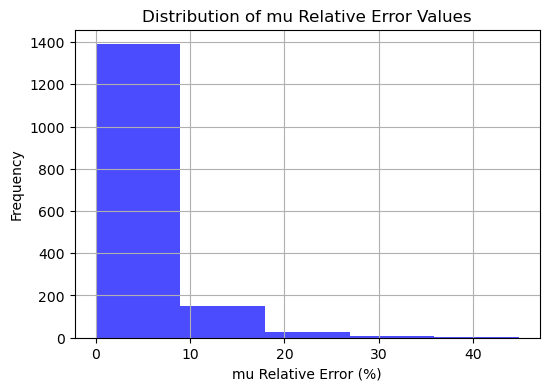

cv rel. error values range from 0.00 to 17.44.
Median cv relative error: 1.46%
3rd quartile cv relative error: 2.89%


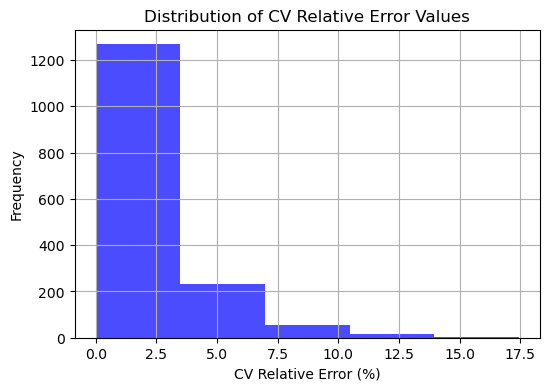

t_ac rel. error values range from 0.00 to 5658.36.
Median t_ac relative error: 5.28%
3rd quartile t_ac relative error: 10.45%


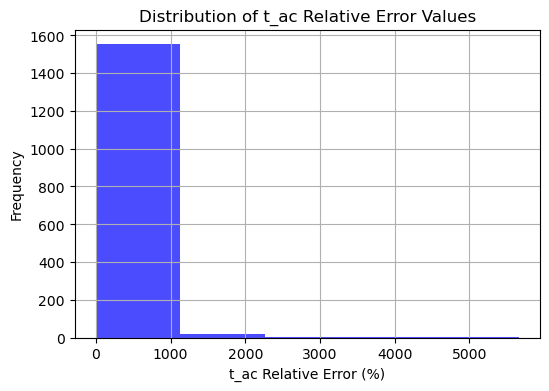

In [25]:
# plot relative error distribution
mu_err_min = success_results['mean_rel_error_pct'].min()
mu_err_max = success_results['mean_rel_error_pct'].max()
print(f"mu rel. error values range from {mu_err_min:.2f} to {mu_err_max:.2f}.")
# median relative error
median_mu_err = success_results['mean_rel_error_pct'].median()
print(f"Median mu relative error: {median_mu_err:.2f}%")
# 3rd quantile
q3_mu_err = success_results['mean_rel_error_pct'].quantile(0.75)
print(f"3rd quartile mu relative error: {q3_mu_err:.2f}%")
# plot the distribution 
plt.figure(figsize=(6, 4))
plt.hist(success_results['mean_rel_error_pct'], bins=5, color='blue', alpha=0.7)
plt.xlabel('mu Relative Error (%)')
plt.ylabel('Frequency')
plt.title('Distribution of mu Relative Error Values')
plt.grid()  
plt.show()
# --
# plot dist for the other errors
cv_err_min = success_results['cv_rel_error_pct'].min()
cv_err_max = success_results['cv_rel_error_pct'].max()
print(f"cv rel. error values range from {cv_err_min:.2f} to {cv_err_max:.2f}.")
# median relative error
median_cv_err = success_results['cv_rel_error_pct'].median()
print(f"Median cv relative error: {median_cv_err:.2f}%")
# 3rd quantile
q3_cv_err = success_results['cv_rel_error_pct'].quantile(0.75)
print(f"3rd quartile cv relative error: {q3_cv_err:.2f}%")
# plot the distribution 
plt.figure(figsize=(6, 4))
plt.hist(success_results['cv_rel_error_pct'], bins=5, color='blue', alpha=0.7)
plt.xlabel('CV Relative Error (%)')
plt.ylabel('Frequency')
plt.title('Distribution of CV Relative Error Values')
plt.grid()  
plt.show()
# -- 
t_ac_err_min = success_results['ac_rel_error_pct'].min()    
t_ac_err_max = success_results['ac_rel_error_pct'].max()
print(f"t_ac rel. error values range from {t_ac_err_min:.2f} to {t_ac_err_max:.2f}.")
# median relative error
median_t_ac_err = success_results['ac_rel_error_pct'].median()
print(f"Median t_ac relative error: {median_t_ac_err:.2f}%")
# 3rd quantile
q3_t_ac_err = success_results['ac_rel_error_pct'].quantile(0.75)
print(f"3rd quartile t_ac relative error: {q3_t_ac_err:.2f}%")
# plot the distribution
plt.figure(figsize=(6, 4))
plt.hist(success_results['ac_rel_error_pct'], bins=5, color='blue', alpha=0.7)
plt.xlabel('t_ac Relative Error (%)')
plt.ylabel('Frequency')
plt.title('Distribution of t_ac Relative Error Values')
plt.grid()  
plt.show()

Use the above insights to narrow down to cases where relative errors are small

Success rate (less than 20% relative error): 68.05% (1361 out of 2000)


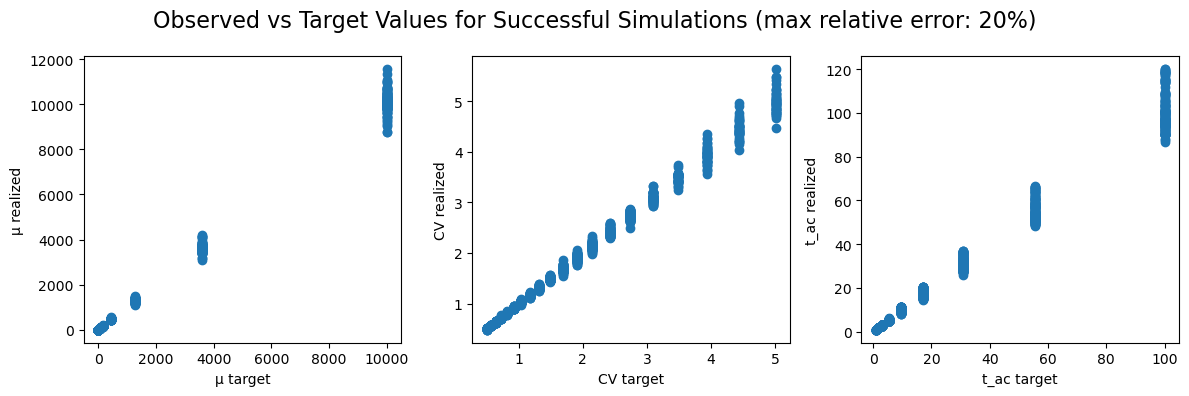

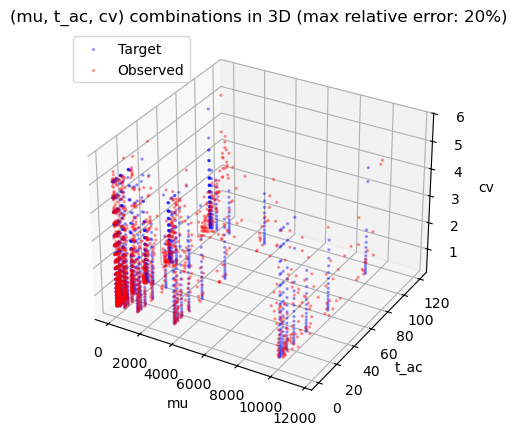

CV target values range from 0.50 to 5.01.
Observed CV values range from 0.48 to 5.63.


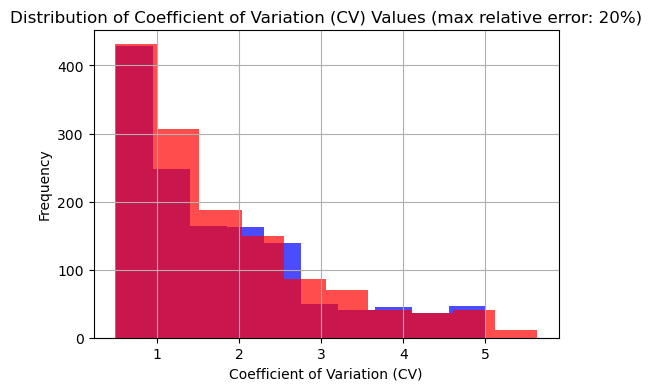

mu target values range from 1.00 to 10000.00.
Observed mu values range from 0.84 to 11560.70.


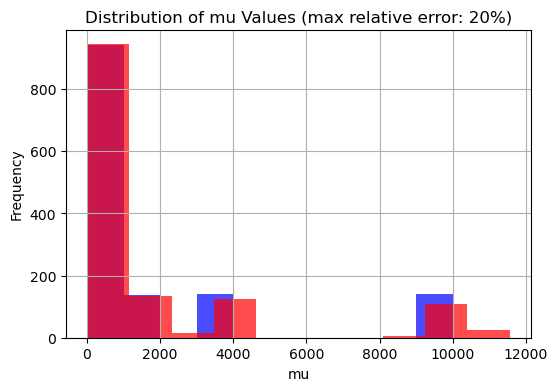

t_ac target values range from 0.90 to 100.00.
Observed t_ac values range from 0.92 to 119.99.


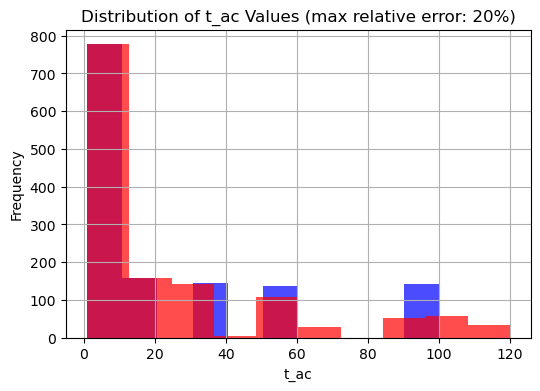

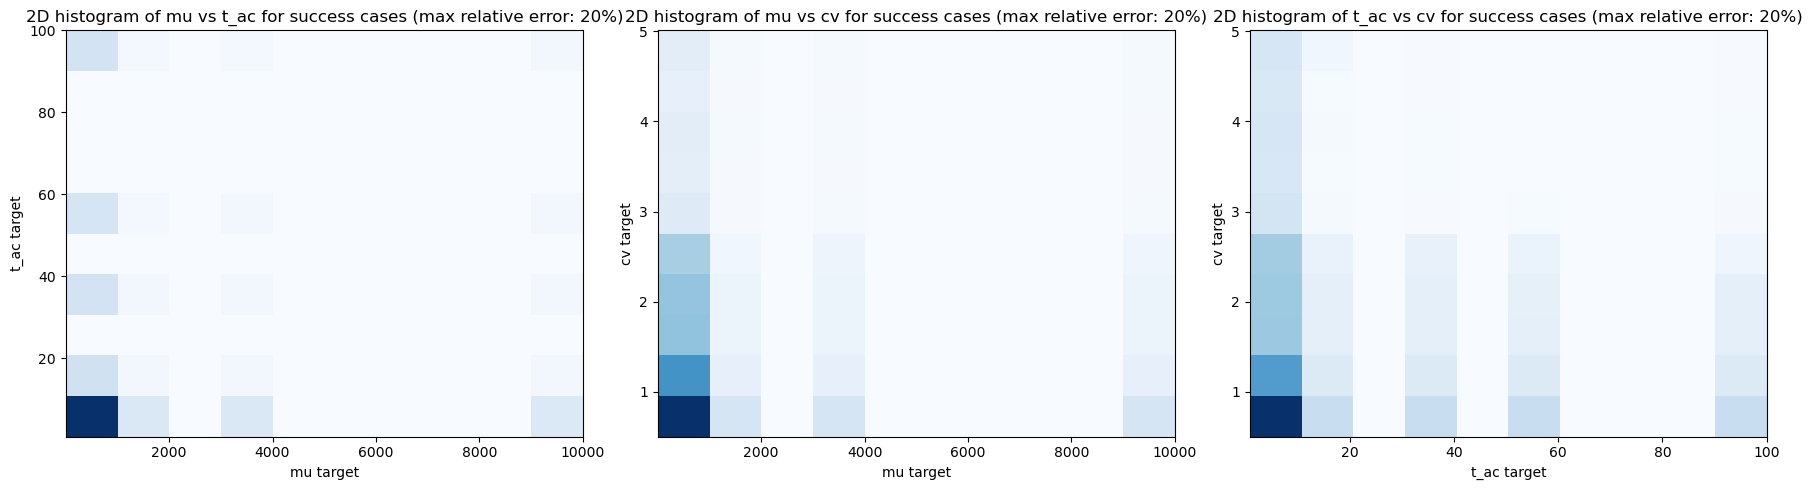

In [28]:
max_rel_err = 20
success_results_20pct_err = success_results[
    (success_results['mean_rel_error_pct'] < max_rel_err) &
    (success_results['cv_rel_error_pct'] < max_rel_err) &
    (success_results['ac_rel_error_pct'] < max_rel_err)
].reset_index(drop=True)
success_rate_20pct_err = len(success_results_20pct_err) / len(results)
print(f'Success rate (less than {max_rel_err}% relative error): {success_rate_20pct_err:.2%} ({len(success_results_20pct_err)} out of {len(results)})')

fig, axes = plt.subplots(1,3, figsize=(12,4))
plt.suptitle(f'Observed vs Target Values for Successful Simulations (max relative error: {max_rel_err}%)', fontsize=16)
axes[0].scatter(success_results_20pct_err['mu_target'], success_results_20pct_err['mu_observed'])
axes[0].set_xlabel('μ target'); axes[0].set_ylabel('μ realized')
axes[1].scatter(success_results_20pct_err['cv_target'], success_results_20pct_err['cv_observed'])
axes[1].set_xlabel('CV target'); axes[1].set_ylabel('CV realized')
axes[2].scatter(success_results_20pct_err['t_ac_target'], success_results_20pct_err['t_ac_observed'])
axes[2].set_xlabel('t_ac target'); axes[2].set_ylabel('t_ac realized')
plt.tight_layout()
plt.show()
# -- 
success_results = success_results_20pct_err
# Create a 3D scatter plot of mu vs t_ac vs cv
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(success_results['mu_target'], success_results['t_ac_target'], success_results['cv_target'], s=2, alpha=0.3, color='blue')
ax.scatter(success_results['mu_observed'], success_results['t_ac_observed'], success_results['cv_observed'], s=2, alpha=0.3, color='red')
ax.legend(['Target', 'Observed'], loc='upper left')
ax.set_xlabel('mu')
ax.set_ylabel('t_ac')
ax.set_zlabel('cv')
ax.set_title(f'(mu, t_ac, cv) combinations in 3D (max relative error: {max_rel_err}%)')
plt.show()
# data distribution plots: CV
cv_target_min = success_results['cv_target'].min()
cv_target_max = success_results['cv_target'].max()
print(f"CV target values range from {cv_target_min:.2f} to {cv_target_max:.2f}.")
cv_observed_min = success_results['cv_observed'].min()
cv_observed_max = success_results['cv_observed'].max()
print(f"Observed CV values range from {cv_observed_min:.2f} to {cv_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['cv_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['cv_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('Coefficient of Variation (CV)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Coefficient of Variation (CV) Values (max relative error: {max_rel_err}%)')
plt.grid()  
plt.show()
# data distribution plots: Mu
mu_target_min = success_results['mu_target'].min()
mu_target_max = success_results['mu_target'].max()
print(f"mu target values range from {mu_target_min:.2f} to {mu_target_max:.2f}.")
mu_observed_min = success_results['mu_observed'].min()
mu_observed_max = success_results['mu_observed'].max()
print(f"Observed mu values range from {mu_observed_min:.2f} to {mu_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['mu_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['mu_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('mu')
plt.ylabel('Frequency')
plt.title(f'Distribution of mu Values (max relative error: {max_rel_err}%)')
plt.grid()  
plt.show()
# data distribution plots: t_ac
t_ac_target_min = success_results['t_ac_target'].min()
t_ac_target_max = success_results['t_ac_target'].max()
print(f"t_ac target values range from {t_ac_target_min:.2f} to {t_ac_target_max:.2f}.")
t_ac_observed_min = success_results['t_ac_observed'].min()
t_ac_observed_max = success_results['t_ac_observed'].max()
print(f"Observed t_ac values range from {t_ac_observed_min:.2f} to {t_ac_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['t_ac_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['t_ac_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('t_ac')
plt.ylabel('Frequency')
plt.title(f'Distribution of t_ac Values (max relative error: {max_rel_err}%)')
plt.grid()  
plt.show()
# pairwise plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].hist2d(success_results['mu_target'], success_results['t_ac_target'], bins=10, cmap='Blues')
axes[0].set_xlabel('mu target')
axes[0].set_ylabel('t_ac target')
axes[0].set_title(f'2D histogram of mu vs t_ac for success cases (max relative error: {max_rel_err}%)')
axes[1].hist2d(success_results['mu_target'], success_results['cv_target'], bins=10, cmap='Blues')
axes[1].set_xlabel('mu target')
axes[1].set_ylabel('cv target')
axes[1].set_title(f'2D histogram of mu vs cv for success cases (max relative error: {max_rel_err}%)')
axes[2].hist2d(success_results['t_ac_target'], success_results['cv_target'], bins=10, cmap='Blues')
axes[2].set_xlabel('t_ac target')
axes[2].set_ylabel('cv target')
axes[2].set_title(f'2D histogram of t_ac vs cv for success cases (max relative error: {max_rel_err}%)')
plt.tight_layout()
plt.show()  

Success rate (less than 10% relative error): 56.55% (1131 out of 2000)


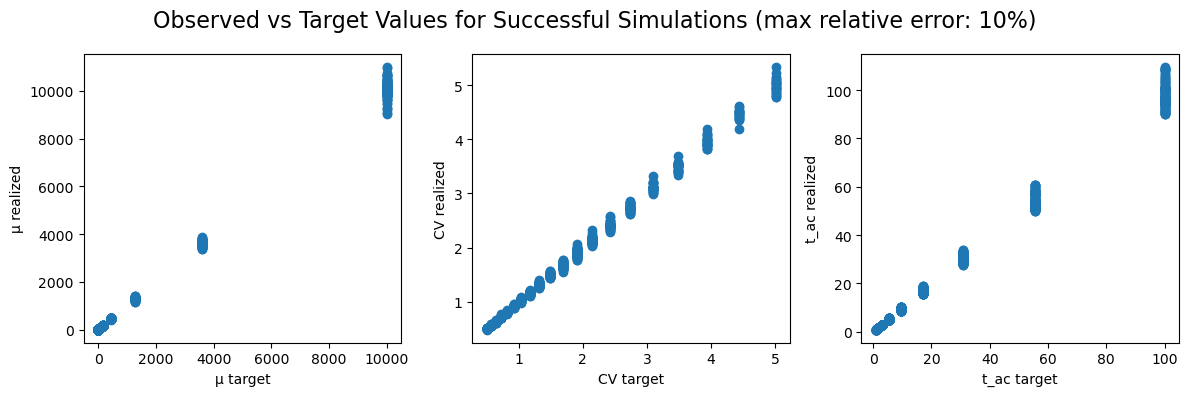

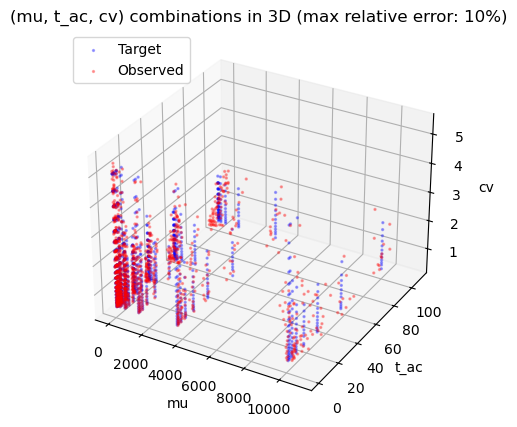

CV target values range from 0.50 to 5.01.
Observed CV values range from 0.49 to 5.33.


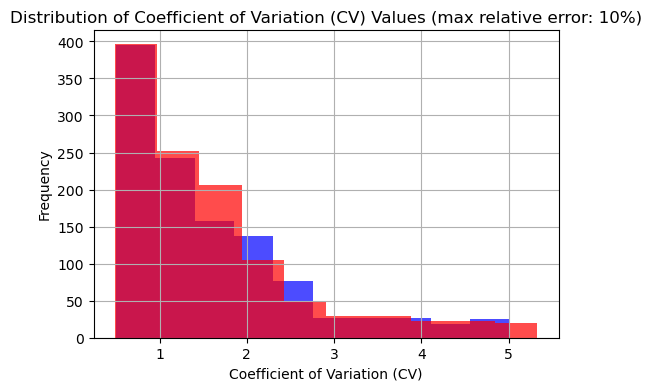

mu target values range from 1.00 to 10000.00.
Observed mu values range from 0.90 to 10997.92.


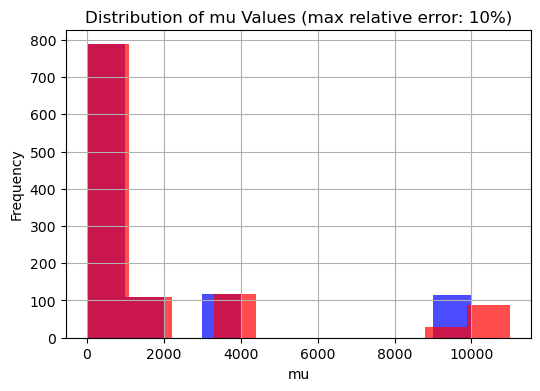

t_ac target values range from 0.90 to 100.00.
Observed t_ac values range from 0.92 to 109.46.


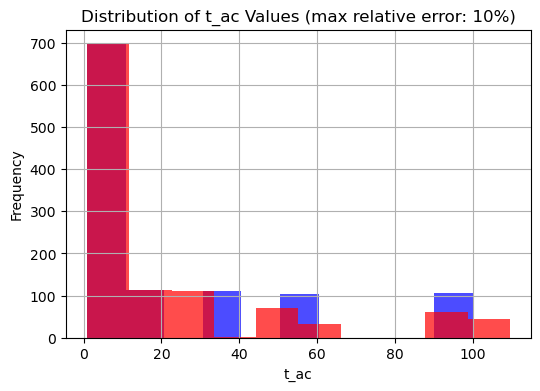

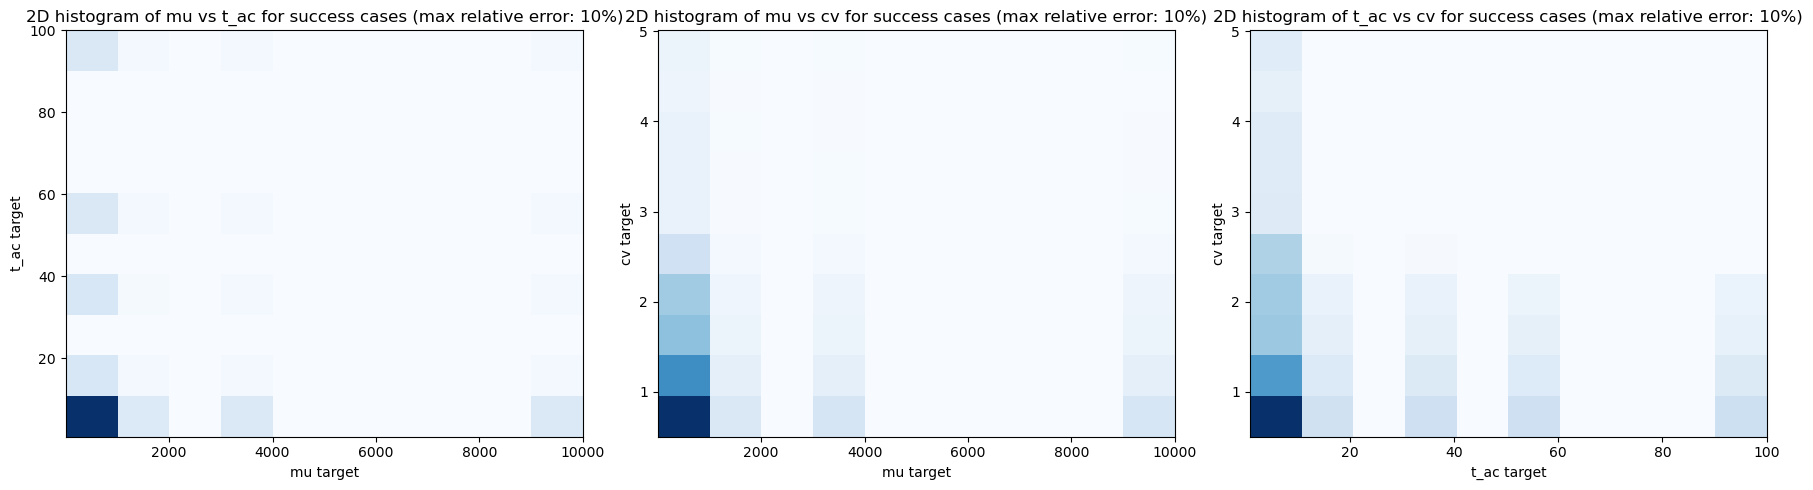

In [29]:
max_rel_err = 10
success_results_10pct_err = success_results[
    (success_results['mean_rel_error_pct'] < max_rel_err) &
    (success_results['cv_rel_error_pct'] < max_rel_err) &
    (success_results['ac_rel_error_pct'] < max_rel_err)
].reset_index(drop=True)
success_rate_10pct_err = len(success_results_10pct_err) / len(results)
print(f'Success rate (less than {max_rel_err}% relative error): {success_rate_10pct_err:.2%} ({len(success_results_10pct_err)} out of {len(results)})')

fig, axes = plt.subplots(1,3, figsize=(12,4))
plt.suptitle(f'Observed vs Target Values for Successful Simulations (max relative error: {max_rel_err}%)', fontsize=16)
axes[0].scatter(success_results_10pct_err['mu_target'], success_results_10pct_err['mu_observed'])
axes[0].set_xlabel('μ target'); axes[0].set_ylabel('μ realized')
axes[1].scatter(success_results_10pct_err['cv_target'], success_results_10pct_err['cv_observed'])
axes[1].set_xlabel('CV target'); axes[1].set_ylabel('CV realized')
axes[2].scatter(success_results_10pct_err['t_ac_target'], success_results_10pct_err['t_ac_observed'])
axes[2].set_xlabel('t_ac target'); axes[2].set_ylabel('t_ac realized')
plt.tight_layout()
plt.show()
# -- 
success_results = success_results_10pct_err
# Create a 3D scatter plot of mu vs t_ac vs cv
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(success_results['mu_target'], success_results['t_ac_target'], success_results['cv_target'], s=2, alpha=0.3, color='blue')
ax.scatter(success_results['mu_observed'], success_results['t_ac_observed'], success_results['cv_observed'], s=2, alpha=0.3, color='red')
ax.legend(['Target', 'Observed'], loc='upper left')
ax.set_xlabel('mu')
ax.set_ylabel('t_ac')
ax.set_zlabel('cv')
ax.set_title(f'(mu, t_ac, cv) combinations in 3D (max relative error: {max_rel_err}%)')
plt.show()
# data distribution plots: CV
cv_target_min = success_results['cv_target'].min()
cv_target_max = success_results['cv_target'].max()
print(f"CV target values range from {cv_target_min:.2f} to {cv_target_max:.2f}.")
cv_observed_min = success_results['cv_observed'].min()
cv_observed_max = success_results['cv_observed'].max()
print(f"Observed CV values range from {cv_observed_min:.2f} to {cv_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['cv_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['cv_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('Coefficient of Variation (CV)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Coefficient of Variation (CV) Values (max relative error: {max_rel_err}%)')
plt.grid()  
plt.show()
# data distribution plots: Mu
mu_target_min = success_results['mu_target'].min()
mu_target_max = success_results['mu_target'].max()
print(f"mu target values range from {mu_target_min:.2f} to {mu_target_max:.2f}.")
mu_observed_min = success_results['mu_observed'].min()
mu_observed_max = success_results['mu_observed'].max()
print(f"Observed mu values range from {mu_observed_min:.2f} to {mu_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['mu_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['mu_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('mu')
plt.ylabel('Frequency')
plt.title(f'Distribution of mu Values (max relative error: {max_rel_err}%)')
plt.grid()  
plt.show()
# data distribution plots: t_ac
t_ac_target_min = success_results['t_ac_target'].min()
t_ac_target_max = success_results['t_ac_target'].max()
print(f"t_ac target values range from {t_ac_target_min:.2f} to {t_ac_target_max:.2f}.")
t_ac_observed_min = success_results['t_ac_observed'].min()
t_ac_observed_max = success_results['t_ac_observed'].max()
print(f"Observed t_ac values range from {t_ac_observed_min:.2f} to {t_ac_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['t_ac_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['t_ac_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('t_ac')
plt.ylabel('Frequency')
plt.title(f'Distribution of t_ac Values (max relative error: {max_rel_err}%)')
plt.grid()  
plt.show()
# pairwise plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].hist2d(success_results['mu_target'], success_results['t_ac_target'], bins=10, cmap='Blues')
axes[0].set_xlabel('mu target')
axes[0].set_ylabel('t_ac target')
axes[0].set_title(f'2D histogram of mu vs t_ac for success cases (max relative error: {max_rel_err}%)')
axes[1].hist2d(success_results['mu_target'], success_results['cv_target'], bins=10, cmap='Blues')
axes[1].set_xlabel('mu target')
axes[1].set_ylabel('cv target')
axes[1].set_title(f'2D histogram of mu vs cv for success cases (max relative error: {max_rel_err}%)')
axes[2].hist2d(success_results['t_ac_target'], success_results['cv_target'], bins=10, cmap='Blues')
axes[2].set_xlabel('t_ac target')
axes[2].set_ylabel('cv target')
axes[2].set_title(f'2D histogram of t_ac vs cv for success cases (max relative error: {max_rel_err}%)')
plt.tight_layout()
plt.show()  

Success rate (less than 5% relative error): 31.75% (635 out of 2000)


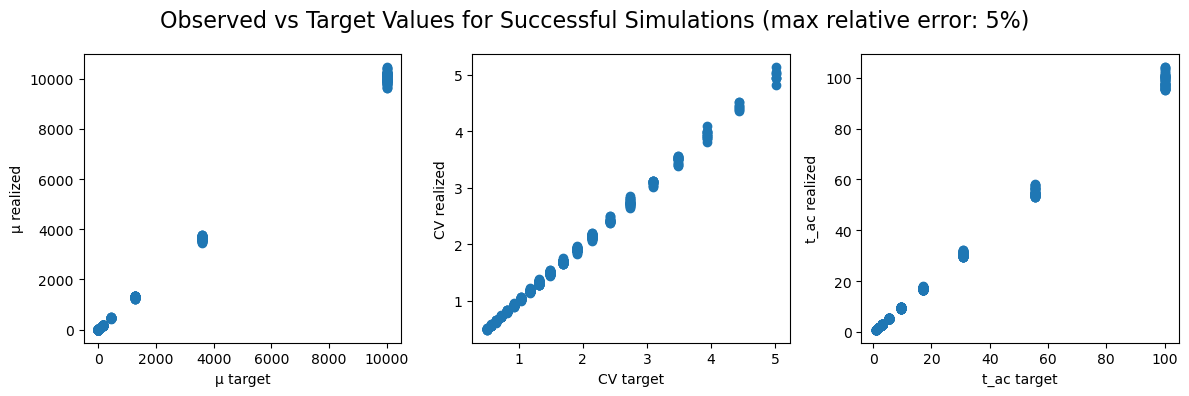

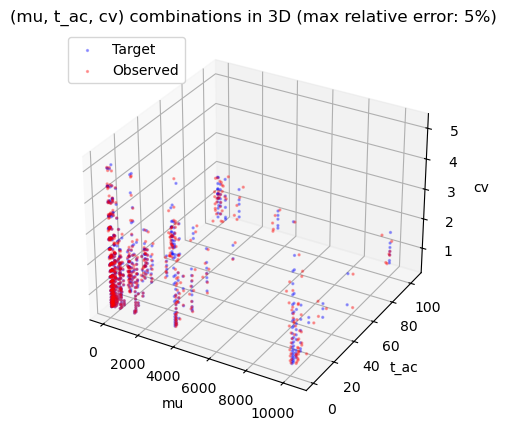

CV target values range from 0.50 to 5.01.
Observed CV values range from 0.49 to 5.13.


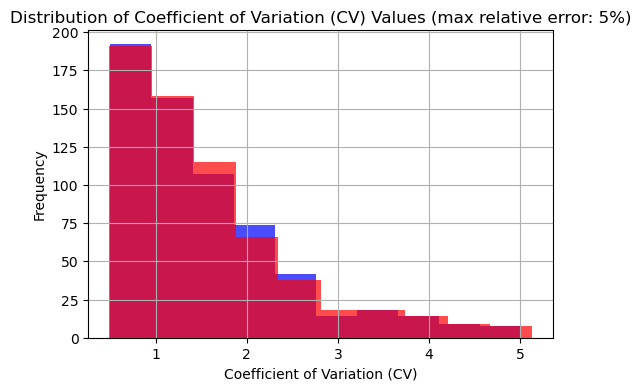

mu target values range from 1.00 to 10000.00.
Observed mu values range from 0.96 to 10459.57.


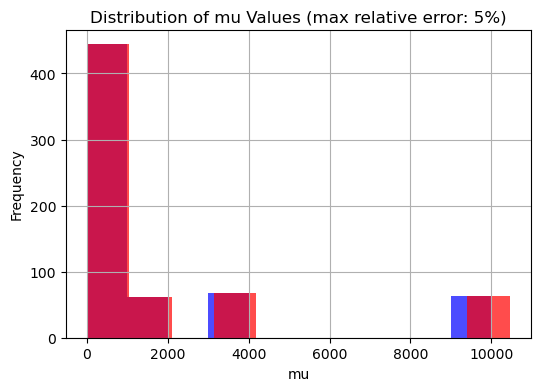

t_ac target values range from 0.90 to 100.00.
Observed t_ac values range from 0.92 to 104.14.


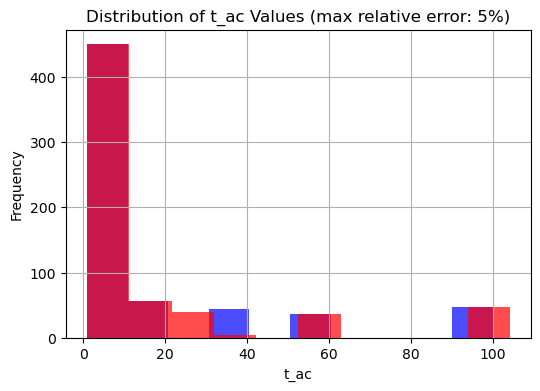

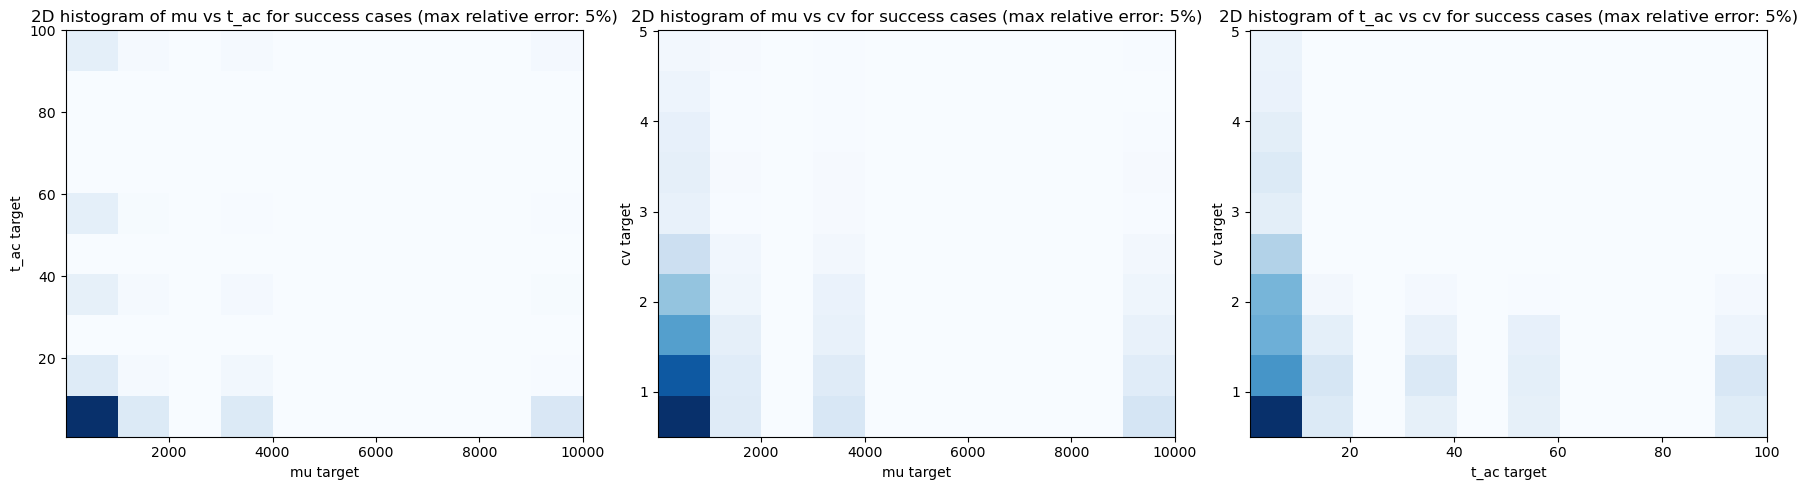

In [31]:
# get cases where relative errors are less than 5%, from success_stats
max_rel_err = 5
success_results_5pct_err = success_results[
    (success_results['mean_rel_error_pct'] < max_rel_err) &
    (success_results['cv_rel_error_pct'] < max_rel_err) &
    (success_results['ac_rel_error_pct'] < max_rel_err)
].reset_index(drop=True)
success_rate_5pct_err = len(success_results_5pct_err) / len(results)
print(f'Success rate (less than {max_rel_err}% relative error): {success_rate_5pct_err:.2%} ({len(success_results_5pct_err)} out of {len(results)})')

fig, axes = plt.subplots(1,3, figsize=(12,4))
plt.suptitle(f'Observed vs Target Values for Successful Simulations (max relative error: {max_rel_err}%)', fontsize=16)
axes[0].scatter(success_results_5pct_err['mu_target'], success_results_5pct_err['mu_observed'])
axes[0].set_xlabel('μ target'); axes[0].set_ylabel('μ realized')
axes[1].scatter(success_results_5pct_err['cv_target'], success_results_5pct_err['cv_observed'])
axes[1].set_xlabel('CV target'); axes[1].set_ylabel('CV realized')
axes[2].scatter(success_results_5pct_err['t_ac_target'], success_results_5pct_err['t_ac_observed'])
axes[2].set_xlabel('t_ac target'); axes[2].set_ylabel('t_ac realized')
plt.tight_layout()
plt.show()

# -- 
success_results = success_results_5pct_err
# Create a 3D scatter plot of mu vs t_ac vs cv
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(success_results['mu_target'], success_results['t_ac_target'], success_results['cv_target'], s=2, alpha=0.3, color='blue')
ax.scatter(success_results['mu_observed'], success_results['t_ac_observed'], success_results['cv_observed'], s=2, alpha=0.3, color='red')
ax.legend(['Target', 'Observed'], loc='upper left')
ax.set_xlabel('mu')
ax.set_ylabel('t_ac')
ax.set_zlabel('cv')
ax.set_title(f'(mu, t_ac, cv) combinations in 3D (max relative error: {max_rel_err}%)')
plt.show()
# data distribution plots: CV
cv_target_min = success_results['cv_target'].min()
cv_target_max = success_results['cv_target'].max()
print(f"CV target values range from {cv_target_min:.2f} to {cv_target_max:.2f}.")
cv_observed_min = success_results['cv_observed'].min()
cv_observed_max = success_results['cv_observed'].max()
print(f"Observed CV values range from {cv_observed_min:.2f} to {cv_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['cv_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['cv_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('Coefficient of Variation (CV)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Coefficient of Variation (CV) Values (max relative error: {max_rel_err}%)')
plt.grid()  
plt.show()
# data distribution plots: Mu
mu_target_min = success_results['mu_target'].min()
mu_target_max = success_results['mu_target'].max()
print(f"mu target values range from {mu_target_min:.2f} to {mu_target_max:.2f}.")
mu_observed_min = success_results['mu_observed'].min()
mu_observed_max = success_results['mu_observed'].max()
print(f"Observed mu values range from {mu_observed_min:.2f} to {mu_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['mu_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['mu_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('mu')
plt.ylabel('Frequency')
plt.title(f'Distribution of mu Values (max relative error: {max_rel_err}%)')
plt.grid()  
plt.show()
# data distribution plots: t_ac
t_ac_target_min = success_results['t_ac_target'].min()
t_ac_target_max = success_results['t_ac_target'].max()
print(f"t_ac target values range from {t_ac_target_min:.2f} to {t_ac_target_max:.2f}.")
t_ac_observed_min = success_results['t_ac_observed'].min()
t_ac_observed_max = success_results['t_ac_observed'].max()
print(f"Observed t_ac values range from {t_ac_observed_min:.2f} to {t_ac_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['t_ac_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['t_ac_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('t_ac')
plt.ylabel('Frequency')
plt.title(f'Distribution of t_ac Values (max relative error: {max_rel_err}%)')
plt.grid()  
plt.show()
# pairwise plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].hist2d(success_results['mu_target'], success_results['t_ac_target'], bins=10, cmap='Blues')
axes[0].set_xlabel('mu target')
axes[0].set_ylabel('t_ac target')
axes[0].set_title(f'2D histogram of mu vs t_ac for success cases (max relative error: {max_rel_err}%)')
axes[1].hist2d(success_results['mu_target'], success_results['cv_target'], bins=10, cmap='Blues')
axes[1].set_xlabel('mu target')
axes[1].set_ylabel('cv target')
axes[1].set_title(f'2D histogram of mu vs cv for success cases (max relative error: {max_rel_err}%)')
axes[2].hist2d(success_results['t_ac_target'], success_results['cv_target'], bins=10, cmap='Blues')
axes[2].set_xlabel('t_ac target')
axes[2].set_ylabel('cv target')
axes[2].set_title(f'2D histogram of t_ac vs cv for success cases (max relative error: {max_rel_err}%)')
plt.tight_layout()
plt.show()  

Success rate (less than 2% relative error): 6.15% (123 out of 2000)


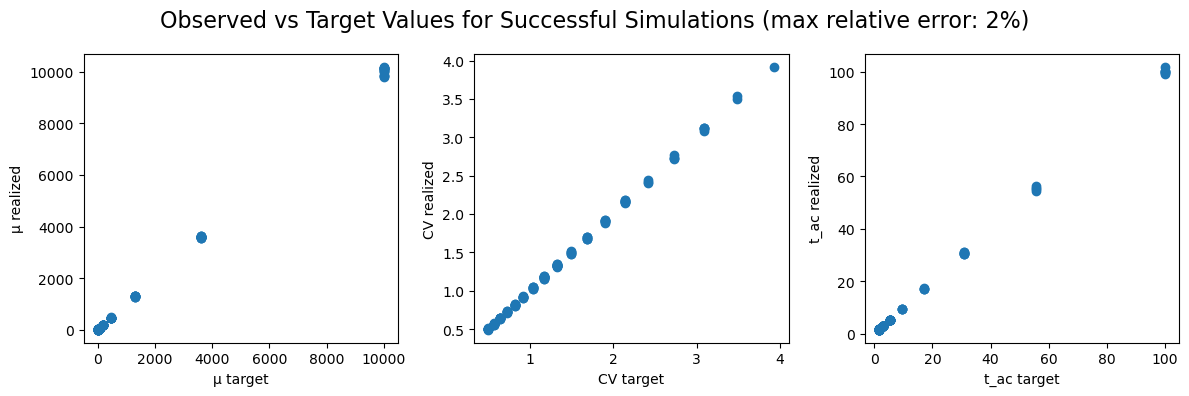

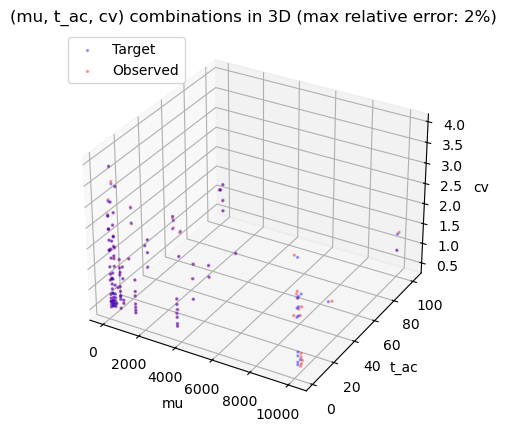

CV target values range from 0.50 to 3.93.
Observed CV values range from 0.49 to 3.91.


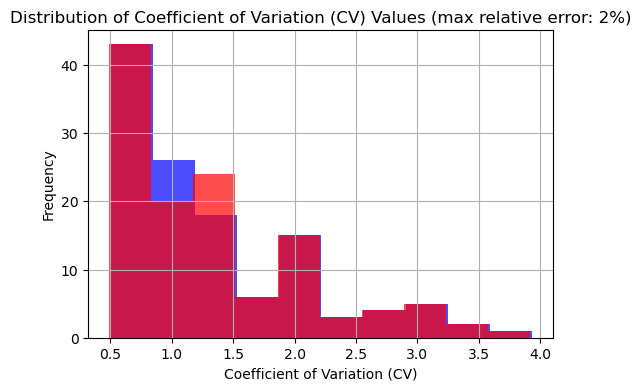

mu target values range from 1.00 to 10000.00.
Observed mu values range from 0.98 to 10184.63.


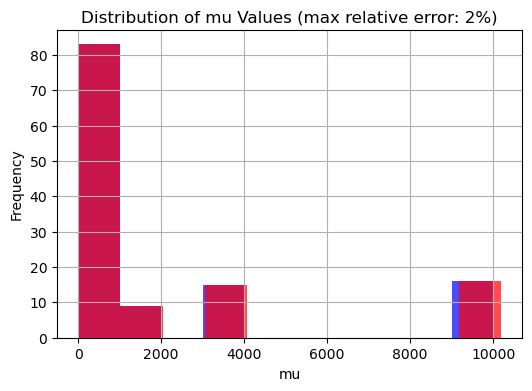

t_ac target values range from 1.63 to 100.00.
Observed t_ac values range from 1.60 to 101.69.


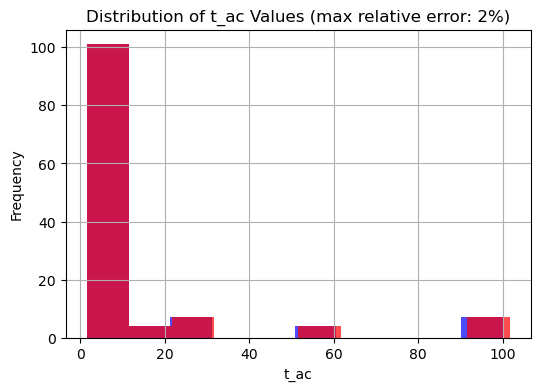

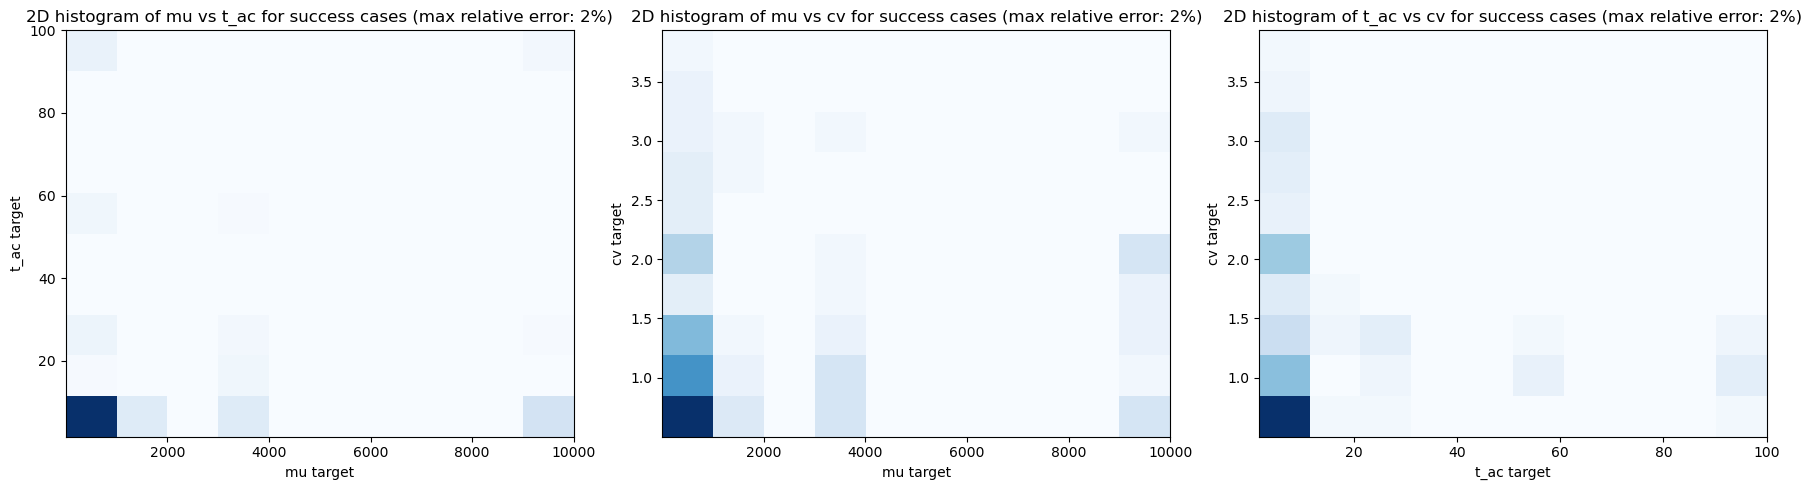

In [39]:
# get cases where relative errors are less than 2%, from success_stats
max_rel_err = 2
success_results_2pct_err = success_results[
    (success_results['mean_rel_error_pct'] < max_rel_err) &
    (success_results['cv_rel_error_pct'] < max_rel_err) &
    (success_results['ac_rel_error_pct'] < max_rel_err)
].reset_index(drop=True)
success_rate_2pct_err = len(success_results_2pct_err) / len(results)
print(f'Success rate (less than {max_rel_err}% relative error): {success_rate_2pct_err:.2%} ({len(success_results_2pct_err)} out of {len(results)})')

fig, axes = plt.subplots(1,3, figsize=(12,4))
plt.suptitle(f'Observed vs Target Values for Successful Simulations (max relative error: {max_rel_err}%)', fontsize=16)
axes[0].scatter(success_results_2pct_err['mu_target'], success_results_2pct_err['mu_observed'])
axes[0].set_xlabel('μ target'); axes[0].set_ylabel('μ realized')
axes[1].scatter(success_results_2pct_err['cv_target'], success_results_2pct_err['cv_observed'])
axes[1].set_xlabel('CV target'); axes[1].set_ylabel('CV realized')
axes[2].scatter(success_results_2pct_err['t_ac_target'], success_results_2pct_err['t_ac_observed'])
axes[2].set_xlabel('t_ac target'); axes[2].set_ylabel('t_ac realized')
plt.tight_layout()
plt.show()

# -- 
success_results = success_results_2pct_err
# Create a 3D scatter plot of mu vs t_ac vs cv
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(success_results['mu_target'], success_results['t_ac_target'], success_results['cv_target'], s=2, alpha=0.3, color='blue')
ax.scatter(success_results['mu_observed'], success_results['t_ac_observed'], success_results['cv_observed'], s=2, alpha=0.3, color='red')
ax.legend(['Target', 'Observed'], loc='upper left')
ax.set_xlabel('mu')
ax.set_ylabel('t_ac')
ax.set_zlabel('cv')
ax.set_title(f'(mu, t_ac, cv) combinations in 3D (max relative error: {max_rel_err}%)')
plt.show()
# data distribution plots: CV
cv_target_min = success_results['cv_target'].min()
cv_target_max = success_results['cv_target'].max()
print(f"CV target values range from {cv_target_min:.2f} to {cv_target_max:.2f}.")
cv_observed_min = success_results['cv_observed'].min()
cv_observed_max = success_results['cv_observed'].max()
print(f"Observed CV values range from {cv_observed_min:.2f} to {cv_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['cv_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['cv_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('Coefficient of Variation (CV)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Coefficient of Variation (CV) Values (max relative error: {max_rel_err}%)')
plt.grid()  
plt.show()
# data distribution plots: Mu
mu_target_min = success_results['mu_target'].min()
mu_target_max = success_results['mu_target'].max()
print(f"mu target values range from {mu_target_min:.2f} to {mu_target_max:.2f}.")
mu_observed_min = success_results['mu_observed'].min()
mu_observed_max = success_results['mu_observed'].max()
print(f"Observed mu values range from {mu_observed_min:.2f} to {mu_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['mu_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['mu_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('mu')
plt.ylabel('Frequency')
plt.title(f'Distribution of mu Values (max relative error: {max_rel_err}%)')
plt.grid()  
plt.show()
# data distribution plots: t_ac
t_ac_target_min = success_results['t_ac_target'].min()
t_ac_target_max = success_results['t_ac_target'].max()
print(f"t_ac target values range from {t_ac_target_min:.2f} to {t_ac_target_max:.2f}.")
t_ac_observed_min = success_results['t_ac_observed'].min()
t_ac_observed_max = success_results['t_ac_observed'].max()
print(f"Observed t_ac values range from {t_ac_observed_min:.2f} to {t_ac_observed_max:.2f}.")
plt.figure(figsize=(6, 4))
plt.hist(success_results['t_ac_target'], bins=10, color='blue', alpha=0.7)
plt.hist(success_results['t_ac_observed'], bins=10, color='red', alpha=0.7)
plt.xlabel('t_ac')
plt.ylabel('Frequency')
plt.title(f'Distribution of t_ac Values (max relative error: {max_rel_err}%)')
plt.grid()  
plt.show()
# pairwise plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].hist2d(success_results['mu_target'], success_results['t_ac_target'], bins=10, cmap='Blues')
axes[0].set_xlabel('mu target')
axes[0].set_ylabel('t_ac target')
axes[0].set_title(f'2D histogram of mu vs t_ac for success cases (max relative error: {max_rel_err}%)')
axes[1].hist2d(success_results['mu_target'], success_results['cv_target'], bins=10, cmap='Blues')
axes[1].set_xlabel('mu target')
axes[1].set_ylabel('cv target')
axes[1].set_title(f'2D histogram of mu vs cv for success cases (max relative error: {max_rel_err}%)')
axes[2].hist2d(success_results['t_ac_target'], success_results['cv_target'], bins=10, cmap='Blues')
axes[2].set_xlabel('t_ac target')
axes[2].set_ylabel('cv target')
axes[2].set_title(f'2D histogram of t_ac vs cv for success cases (max relative error: {max_rel_err}%)')
plt.tight_layout()
plt.show()  

## Examine Failure Cases
We'll examine cases where relative errors are large.

=== Error Distribution Comparison ===
Standard relative errors:
  Mean μ error: 10.05%
  Mean CV error: 4.43%
  Mean t_ac error: 274.74%

Hybrid relative errors:
  Mean μ error: 10.05%
  Mean CV error: 4.42%
  Mean t_ac error: 273.44%

Number of failure cases:
  Standard metric: 216 cases
  Hybrid metric: 216 cases


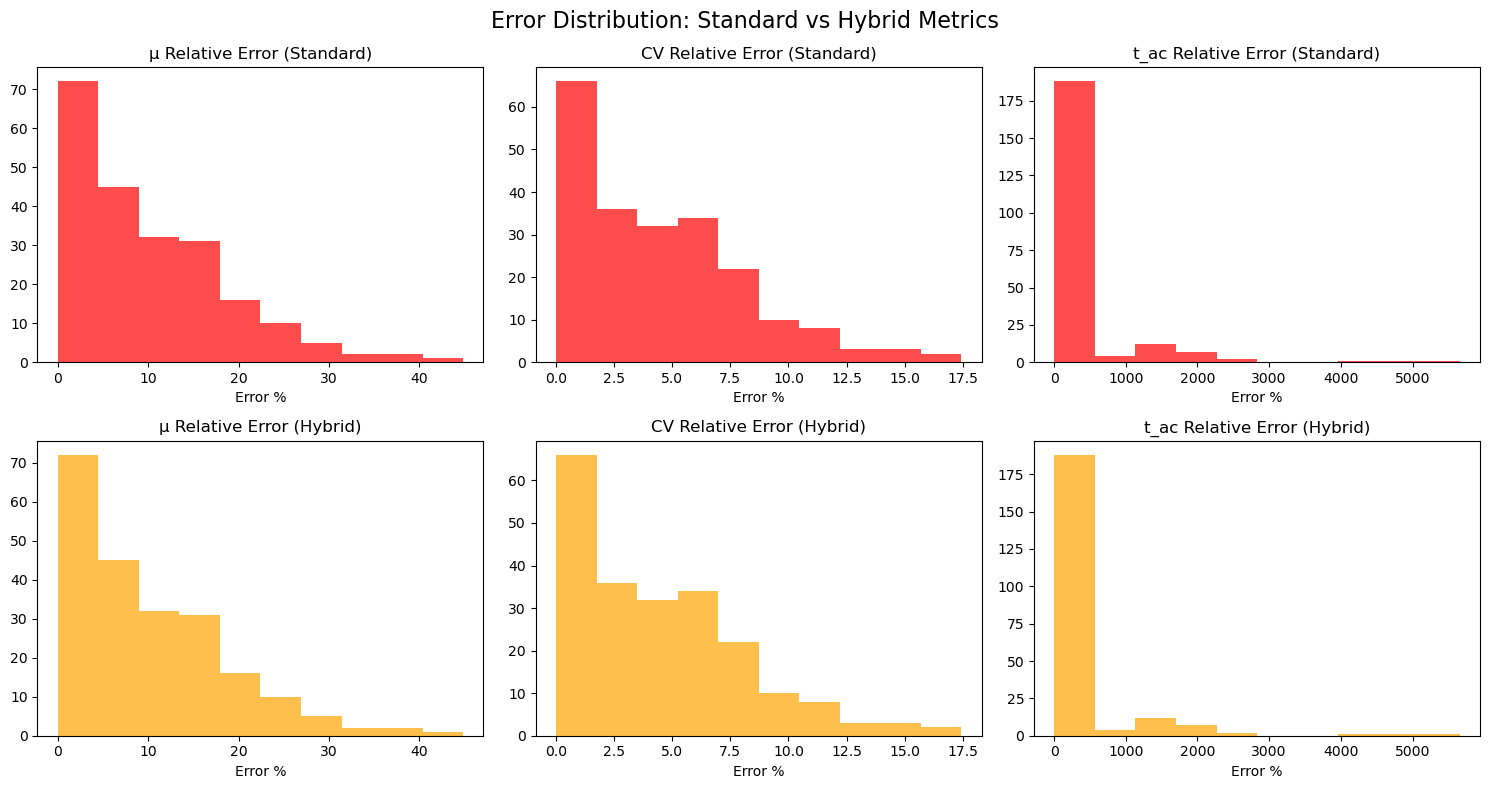

In [ ]:
# 1. Compare error distributions between standard and hybrid metrics
max_rel_err = 20
# reset success_results assignment
success_results = results[results['success'] == True].reset_index(drop=True)
failure_results = success_results[
    (success_results['mean_rel_error_pct'] > max_rel_err) |
    (success_results['cv_rel_error_pct'] > max_rel_err) |
    (success_results['ac_rel_error_pct'] > max_rel_err)
].reset_index(drop=True)
# Recalculate errors with hybrid relative/absolute metric
rel = lambda x, y: abs(x - y) / max(1.0, abs(y))

success_results['mean_rel_error_pct_hybrid'] = success_results.apply(
    lambda r: rel(r['mu_observed'], r['mu_target']) * 100, axis=1
)
success_results['cv_rel_error_pct_hybrid'] = success_results.apply(
    lambda r: rel(r['cv_observed'], r['cv_target']) * 100, axis=1
)
success_results['ac_rel_error_pct_hybrid'] = success_results.apply(
    lambda r: rel(r['t_ac_observed'], r['t_ac_target']) * 100, axis=1
)

failure_results_hybrid = success_results[
    (success_results['mean_rel_error_pct_hybrid'] > max_rel_err) |
    (success_results['cv_rel_error_pct_hybrid'] > max_rel_err) |
    (success_results['ac_rel_error_pct_hybrid'] > max_rel_err)
].reset_index(drop=True)

print("=== Error Distribution Comparison ===")
print("Standard relative errors:")
print(f"  Mean μ error: {failure_results['mean_rel_error_pct'].mean():.2f}%")
print(f"  Mean CV error: {failure_results['cv_rel_error_pct'].mean():.2f}%") 
print(f"  Mean t_ac error: {failure_results['ac_rel_error_pct'].mean():.2f}%")

print("\nHybrid relative errors:")
print(f"  Mean μ error: {failure_results_hybrid['mean_rel_error_pct_hybrid'].mean():.2f}%")
print(f"  Mean CV error: {failure_results_hybrid['cv_rel_error_pct_hybrid'].mean():.2f}%")
print(f"  Mean t_ac error: {failure_results_hybrid['ac_rel_error_pct_hybrid'].mean():.2f}%")

print(f"\nNumber of failure cases:")
print(f"  Standard metric: {len(failure_results)} cases")
print(f"  Hybrid metric: {len(failure_results_hybrid)} cases")

# Plot error distribution comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Error Distribution: Standard vs Hybrid Metrics', fontsize=16)

# Standard errors
axes[0,0].hist(failure_results['mean_rel_error_pct'], bins=10, alpha=0.7, color='red', label='Standard')
axes[0,0].set_title('μ Relative Error (Standard)')
axes[0,0].set_xlabel('Error %')

axes[0,1].hist(failure_results['cv_rel_error_pct'], bins=10, alpha=0.7, color='red')
axes[0,1].set_title('CV Relative Error (Standard)')
axes[0,1].set_xlabel('Error %')

axes[0,2].hist(failure_results['ac_rel_error_pct'], bins=10, alpha=0.7, color='red')
axes[0,2].set_title('t_ac Relative Error (Standard)')
axes[0,2].set_xlabel('Error %')

# Hybrid errors
axes[1,0].hist(failure_results_hybrid['mean_rel_error_pct_hybrid'], bins=10, alpha=0.7, color='orange', label='Hybrid')
axes[1,0].set_title('μ Relative Error (Hybrid)')
axes[1,0].set_xlabel('Error %')

axes[1,1].hist(failure_results_hybrid['cv_rel_error_pct_hybrid'], bins=10, alpha=0.7, color='orange')
axes[1,1].set_title('CV Relative Error (Hybrid)')
axes[1,1].set_xlabel('Error %')

axes[1,2].hist(failure_results_hybrid['ac_rel_error_pct_hybrid'], bins=10, alpha=0.7, color='orange')
axes[1,2].set_title('t_ac Relative Error (Hybrid)')
axes[1,2].set_xlabel('Error %')

plt.tight_layout()
plt.show()

=== Parameter Space Analysis of Failures ===
Parameter ranges in failure cases:
μ range: 1.00 - 10000.00
CV range: 0.50 - 5.01
t_ac range: 0.50 - 100.00


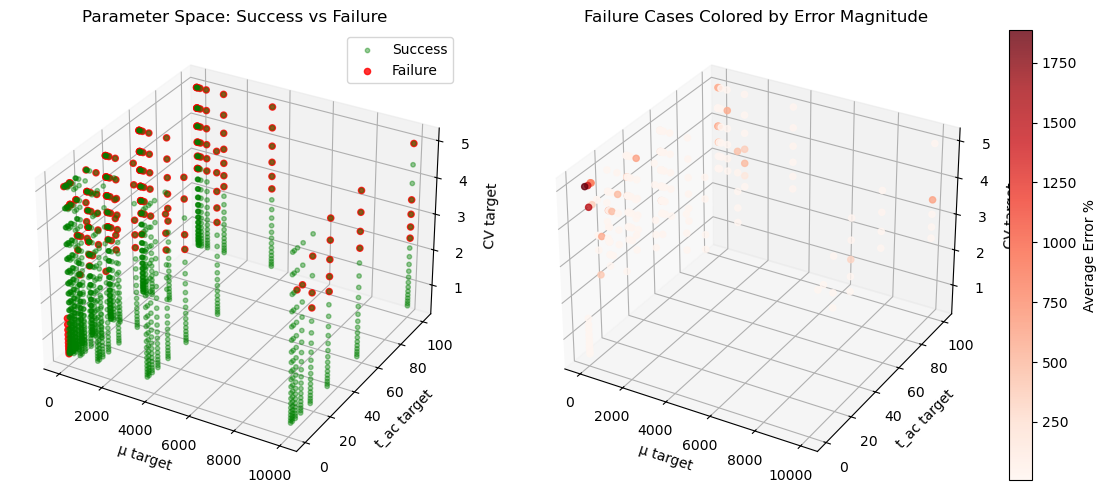

In [46]:
# 2. Analyze which parameter space regions are problematic
print("=== Parameter Space Analysis of Failures ===")

success_results = results[results['success'] == True].reset_index(drop=True)
# Using hybrid metric failures for analysis
failure_data = failure_results_hybrid

print("Parameter ranges in failure cases:")
print(f"μ range: {failure_data['mu_target'].min():.2f} - {failure_data['mu_target'].max():.2f}")
print(f"CV range: {failure_data['cv_target'].min():.2f} - {failure_data['cv_target'].max():.2f}")
print(f"t_ac range: {failure_data['t_ac_target'].min():.2f} - {failure_data['t_ac_target'].max():.2f}")

# Create 3D visualization of failure vs success cases
fig = plt.figure(figsize=(12, 5))

# Success cases in parameter space
ax1 = fig.add_subplot(121, projection='3d')
success_cases = success_results[~success_results.index.isin(failure_data.index)]
ax1.scatter(success_cases['mu_target'], success_cases['t_ac_target'], success_cases['cv_target'], 
           s=10, alpha=0.4, color='green', label='Success')
ax1.scatter(failure_data['mu_target'], failure_data['t_ac_target'], failure_data['cv_target'], 
           s=20, alpha=0.8, color='red', label='Failure')
ax1.set_xlabel('μ target')
ax1.set_ylabel('t_ac target')
ax1.set_zlabel('CV target')
ax1.set_title('Parameter Space: Success vs Failure')
ax1.legend()

# Error magnitude in parameter space
ax2 = fig.add_subplot(122, projection='3d')
# Calculate combined error for color mapping
combined_error = (failure_data['mean_rel_error_pct_hybrid'] + 
                 failure_data['cv_rel_error_pct_hybrid'] + 
                 failure_data['ac_rel_error_pct_hybrid']) / 3
scatter = ax2.scatter(failure_data['mu_target'], failure_data['t_ac_target'], failure_data['cv_target'], 
                     c=combined_error, s=20, alpha=0.8, cmap='Reds')
ax2.set_xlabel('μ target')
ax2.set_ylabel('t_ac target')
ax2.set_zlabel('CV target')
ax2.set_title('Failure Cases Colored by Error Magnitude')
plt.colorbar(scatter, ax=ax2, label='Average Error %')

plt.tight_layout()
plt.show()

=== Parameter-Specific Failure Analysis ===
Relative error magnitude dominated by μ error: 16 cases (7.4%)
Relative error magnitude dominated by CV error: 0 cases (0.0%)
Relative error magnitude dominated by t_ac error: 200 cases (92.6%)


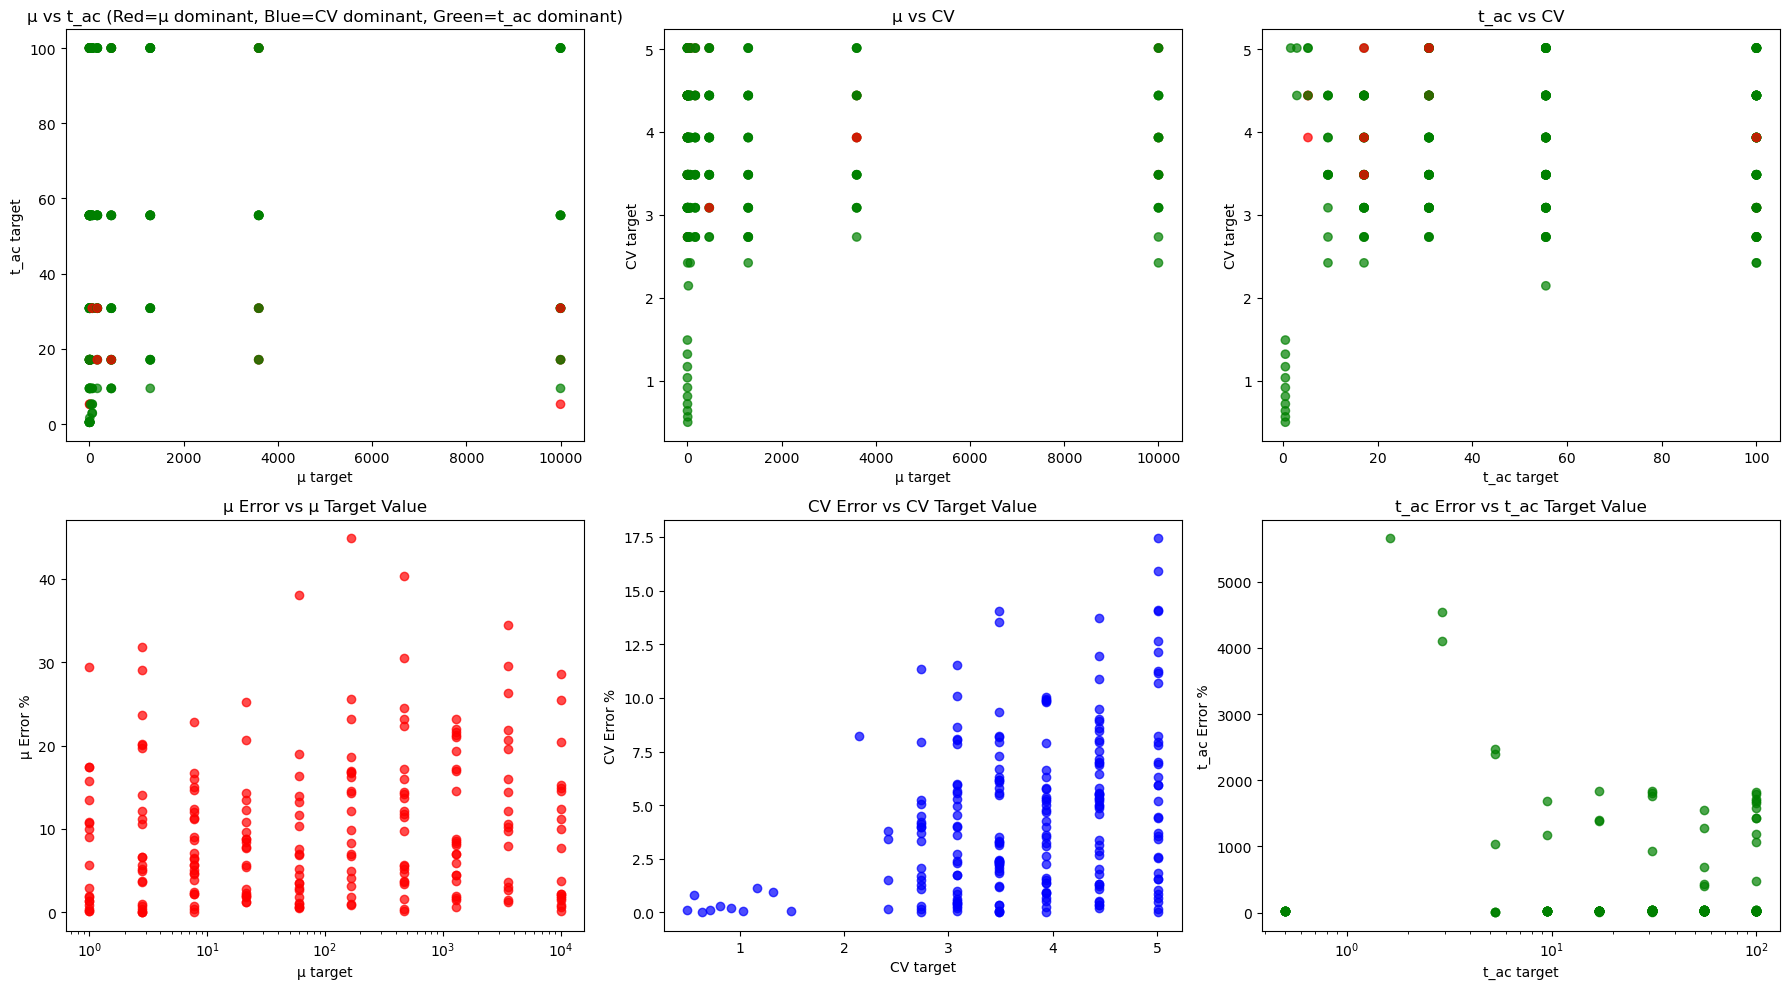

In [48]:
# 3. Identify which parameters contribute most to failures
print("=== Parameter-Specific Failure Analysis ===")

# Count failures by dominant error type
mu_dominant = failure_data['mean_rel_error_pct_hybrid'] > failure_data[['cv_rel_error_pct_hybrid', 'ac_rel_error_pct_hybrid']].max(axis=1)
cv_dominant = failure_data['cv_rel_error_pct_hybrid'] > failure_data[['mean_rel_error_pct_hybrid', 'ac_rel_error_pct_hybrid']].max(axis=1)
tac_dominant = failure_data['ac_rel_error_pct_hybrid'] > failure_data[['mean_rel_error_pct_hybrid', 'cv_rel_error_pct_hybrid']].max(axis=1)

print(f"Relative error magnitude dominated by μ error: {mu_dominant.sum()} cases ({mu_dominant.mean()*100:.1f}%)")
print(f"Relative error magnitude dominated by CV error: {cv_dominant.sum()} cases ({cv_dominant.mean()*100:.1f}%)")
print(f"Relative error magnitude dominated by t_ac error: {tac_dominant.sum()} cases ({tac_dominant.mean()*100:.1f}%)")

# Visualize parameter-specific failures
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Top row: 2D projections of failure cases colored by dominant error
colors = ['red' if mu else 'blue' if cv else 'green' for mu, cv in zip(mu_dominant, cv_dominant)]

axes[0,0].scatter(failure_data['mu_target'], failure_data['t_ac_target'], c=colors, alpha=0.7)
axes[0,0].set_xlabel('μ target')
axes[0,0].set_ylabel('t_ac target')
axes[0,0].set_title('μ vs t_ac (Red=μ dominant, Blue=CV dominant, Green=t_ac dominant)')

axes[0,1].scatter(failure_data['mu_target'], failure_data['cv_target'], c=colors, alpha=0.7)
axes[0,1].set_xlabel('μ target')
axes[0,1].set_ylabel('CV target')
axes[0,1].set_title('μ vs CV')

axes[0,2].scatter(failure_data['t_ac_target'], failure_data['cv_target'], c=colors, alpha=0.7)
axes[0,2].set_xlabel('t_ac target')
axes[0,2].set_ylabel('CV target')
axes[0,2].set_title('t_ac vs CV')

# Bottom row: Error magnitude by parameter value
axes[1,0].scatter(failure_data['mu_target'], failure_data['mean_rel_error_pct_hybrid'], alpha=0.7, color='red')
axes[1,0].set_xlabel('μ target')
axes[1,0].set_ylabel('μ Error %')
axes[1,0].set_title('μ Error vs μ Target Value')
axes[1,0].set_xscale('log')

axes[1,1].scatter(failure_data['cv_target'], failure_data['cv_rel_error_pct_hybrid'], alpha=0.7, color='blue')
axes[1,1].set_xlabel('CV target')
axes[1,1].set_ylabel('CV Error %')
axes[1,1].set_title('CV Error vs CV Target Value')

axes[1,2].scatter(failure_data['t_ac_target'], failure_data['ac_rel_error_pct_hybrid'], alpha=0.7, color='green')
axes[1,2].set_xlabel('t_ac target')
axes[1,2].set_ylabel('t_ac Error %')
axes[1,2].set_title('t_ac Error vs t_ac Target Value')
axes[1,2].set_xscale('log')

plt.tight_layout()
plt.show()

=== Correlation Analysis ===


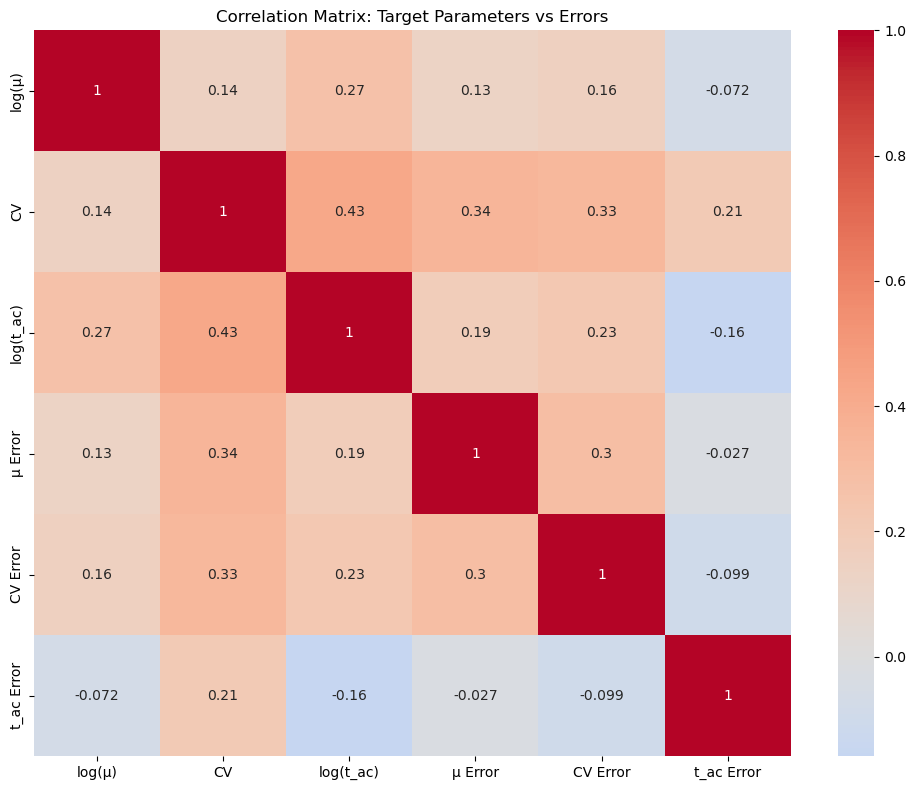

Key correlations:
log(μ) vs μ error: 0.135
CV vs CV error: 0.333
log(t_ac) vs t_ac error: -0.159


In [18]:
# 4. Correlation analysis between target parameters and errors
print("=== Correlation Analysis ===")

# Calculate correlations between target parameters and errors
correlation_data = failure_data[['mu_target', 'cv_target', 't_ac_target', 
                                'mean_rel_error_pct_hybrid', 'cv_rel_error_pct_hybrid', 'ac_rel_error_pct_hybrid']].copy()

# Use log transform for mu and t_ac since they span several orders of magnitude
correlation_data['log_mu_target'] = np.log10(correlation_data['mu_target'])
correlation_data['log_tac_target'] = np.log10(correlation_data['t_ac_target'])

corr_matrix = correlation_data[['log_mu_target', 'cv_target', 'log_tac_target', 
                               'mean_rel_error_pct_hybrid', 'cv_rel_error_pct_hybrid', 'ac_rel_error_pct_hybrid']].corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
import seaborn as sns
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            xticklabels=['log(μ)', 'CV', 'log(t_ac)', 'μ Error', 'CV Error', 't_ac Error'],
            yticklabels=['log(μ)', 'CV', 'log(t_ac)', 'μ Error', 'CV Error', 't_ac Error'])
plt.title('Correlation Matrix: Target Parameters vs Errors')
plt.tight_layout()
plt.show()

print("Key correlations:")
print(f"log(μ) vs μ error: {corr_matrix.loc['log_mu_target', 'mean_rel_error_pct_hybrid']:.3f}")
print(f"CV vs CV error: {corr_matrix.loc['cv_target', 'cv_rel_error_pct_hybrid']:.3f}")
print(f"log(t_ac) vs t_ac error: {corr_matrix.loc['log_tac_target', 'ac_rel_error_pct_hybrid']:.3f}")

=== Extreme Failure Cases ===
Top 10 worst failure cases:
     mu_target  cv_target  t_ac_target  mu_observed  cv_observed  \
44       7.743      5.012        1.626        7.742        4.988   
89      59.948      4.440        2.929       58.221        4.520   
90      59.948      5.012        2.929       69.729        4.792   
68      21.544      5.012        5.275       21.939        4.979   
92      59.948      5.012        5.275       66.136        5.063   
144    464.159      5.012       30.824      407.607        5.328   
51       7.743      3.933       17.113        7.238        3.969   
214  10000.000      3.484      100.000    11531.378        3.291   
9        1.000      3.933       30.824        1.019        4.061   
39       2.783      3.933      100.000        2.921        3.878   

     t_ac_observed  mean_rel_error_pct_hybrid  cv_rel_error_pct_hybrid  \
44          93.629                      0.007                    0.480   
89         135.973                      2.881

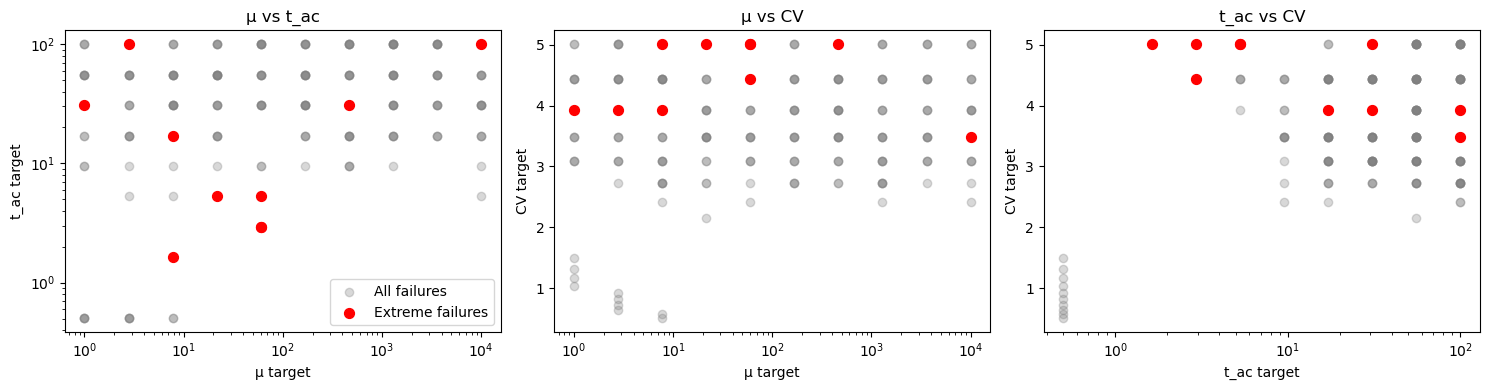

In [19]:
# 5. Examine extreme failure cases
print("=== Extreme Failure Cases ===")

# Find cases with highest errors
failure_data['max_error'] = failure_data[['mean_rel_error_pct_hybrid', 'cv_rel_error_pct_hybrid', 'ac_rel_error_pct_hybrid']].max(axis=1)
extreme_failures = failure_data.nlargest(10, 'max_error')

print("Top 10 worst failure cases:")
print(extreme_failures[['mu_target', 'cv_target', 't_ac_target', 'mu_observed', 'cv_observed', 't_ac_observed',
                        'mean_rel_error_pct_hybrid', 'cv_rel_error_pct_hybrid', 'ac_rel_error_pct_hybrid', 'max_error']].round(3))

# Look for patterns in extreme cases
print(f"\nExtreme failure parameter ranges:")
print(f"μ: {extreme_failures['mu_target'].min():.2f} - {extreme_failures['mu_target'].max():.2f}")
print(f"CV: {extreme_failures['cv_target'].min():.2f} - {extreme_failures['cv_target'].max():.2f}")
print(f"t_ac: {extreme_failures['t_ac_target'].min():.2f} - {extreme_failures['t_ac_target'].max():.2f}")

# Check if extreme cases cluster in certain parameter combinations
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Highlight extreme cases in parameter space
axes[0].scatter(failure_data['mu_target'], failure_data['t_ac_target'], alpha=0.3, color='gray', label='All failures')
axes[0].scatter(extreme_failures['mu_target'], extreme_failures['t_ac_target'], color='red', s=50, label='Extreme failures')
axes[0].set_xlabel('μ target')
axes[0].set_ylabel('t_ac target')
axes[0].set_title('μ vs t_ac')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].legend()

axes[1].scatter(failure_data['mu_target'], failure_data['cv_target'], alpha=0.3, color='gray')
axes[1].scatter(extreme_failures['mu_target'], extreme_failures['cv_target'], color='red', s=50)
axes[1].set_xlabel('μ target')
axes[1].set_ylabel('CV target')
axes[1].set_title('μ vs CV')
axes[1].set_xscale('log')

axes[2].scatter(failure_data['t_ac_target'], failure_data['cv_target'], alpha=0.3, color='gray')
axes[2].scatter(extreme_failures['t_ac_target'], extreme_failures['cv_target'], color='red', s=50)
axes[2].set_xlabel('t_ac target')
axes[2].set_ylabel('CV target')
axes[2].set_title('t_ac vs CV')
axes[2].set_xscale('log')

plt.tight_layout()
plt.show()